# Dataset Unzip

In [8]:
!pip install numpy==1.21.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 60.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for numpy: filename=numpy-1.21.0-cp310-cp310-linux_x86_64.whl size=15985862 sha256=62eba9d139e70324bd6349bc7439d8a6bcd9fe7ef6ec49499573b359fc3ec963
  Stored in directory: /root/.cache/pip/wheels/05/61/d1/ccc2cd557b39e127ad98a392d9558f3c5dda28764b7f54b2f5
Successfully built numpy
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.21.0 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.21.0 w

In [1]:
import numpy
print(numpy.__version__)

1.21.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cd /content/drive/MyDrive/DL_lab4/
!unzip /content/drive/MyDrive/DL_lab4/speech_commands.zip -d /content/drive/MyDrive/DL_lab4/

串流輸出內容已截斷至最後 5000 行。
  inflating: /content/drive/MyDrive/DL_lab4/speech_commands/stop/e7ea8b76_nohash_3.wav  
  inflating: /content/drive/MyDrive/DL_lab4/speech_commands/stop/e7ea8b76_nohash_4.wav  
  inflating: /content/drive/MyDrive/DL_lab4/speech_commands/stop/e7ebf59c_nohash_0.wav  
  inflating: /content/drive/MyDrive/DL_lab4/speech_commands/stop/e805a617_nohash_0.wav  
  inflating: /content/drive/MyDrive/DL_lab4/speech_commands/stop/e805a617_nohash_1.wav  
  inflating: /content/drive/MyDrive/DL_lab4/speech_commands/stop/e8b6f6fe_nohash_0.wav  
  inflating: /content/drive/MyDrive/DL_lab4/speech_commands/stop/e8d562ca_nohash_0.wav  
  inflating: /content/drive/MyDrive/DL_lab4/speech_commands/stop/e8e960fd_nohash_0.wav  
  inflating: /content/drive/MyDrive/DL_lab4/speech_commands/stop/e900b652_nohash_0.wav  
  inflating: /content/drive/MyDrive/DL_lab4/speech_commands/stop/e9287461_nohash_0.wav  
  inflating: /content/drive/MyDrive/DL_lab4/speech_commands/stop/e9287461_nohash_1.wav  


# Training

In [3]:
import sys
import os

current_dir = '/content/drive/MyDrive/DL_lab4'
sys.path.append(current_dir)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from speech_command_dataset import SpeechCommandDataset
from torchvision.transforms import Compose
import torchvision.models as models
import model

# from apex import amp

import os,time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
EPOCH = 20
BATCH_SIZE = 32
LR = 1e-3
Weight_decay = 1e-9

In [7]:
# declare dataloader
training_params = {"batch_size": BATCH_SIZE,
                       "shuffle": True,
                       "drop_last": False,
                       "num_workers": 1}

testing_params = {"batch_size": BATCH_SIZE,
                       "shuffle": False,
                       "drop_last": False,
                       "num_workers": 1}

train_set = SpeechCommandDataset()
train_loader = DataLoader(train_set, **training_params)

test_set = SpeechCommandDataset(is_training=False)
test_loader = DataLoader(test_set, **testing_params)

In [8]:
# declare network
net = model.SincNet().cuda()
print(net)

SincNet(
  (sincconv): _Layer(
    (conv0): SincConv1d()
    (logabs): LogAbs()
    (bn): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (features): ModuleList(
    (0): _Layer(
      (conv0): Conv1d(40, 40, kernel_size=(25,), stride=(2,), groups=40)
      (conv1): Conv1d(40, 256, kernel_size=(1,), stride=(1,))
      (relu): ReLU()
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (1): _Layer(
      (conv0): Conv1d(256, 256, kernel_size=(9,), stride=(1,), groups=256)
      (conv1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (relu): ReLU()
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (2): _Layer(
      (conv0): Conv1d(256, 256,

In [9]:
# declare optimizer and loss function
optimizer = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=Weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,  patience=15, verbose=True, eps=1e-09)

loss_func = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
print('Begin training...')

best_accuracy = 0
itertion = 0
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
lr_list = []

for epoch in range(EPOCH):
    net.train()
    start_time = time.time()
    total_train_loss = 0
    total_dloss = 0
    correct = 0
    total = 0
    batch_num = 0

    for step, (audios, labels) in enumerate(tqdm(train_loader, desc="Training", leave=True)):
        audios = audios.cuda()
        labels = labels.cuda()
        outputs = net(audios)

        loss = loss_func(outputs, labels)

        total_train_loss += loss.item()
        batch_num += 1
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    end_time = time.time()
    train_time = end_time - start_time
    train_loss = total_train_loss / batch_num
    train_loss_list.append(train_loss)
    train_acc = 100.0 * float(correct) / float(total)
    train_acc_list.append(train_acc)

    start_time = time.time()
    total_val_loss = 0
    correct = 0
    total = 0
    batch_num = 0

    net.eval()
    for audios, labels in tqdm(test_loader, desc="Testing", leave=True):
        audios = audios.cuda()
        labels = labels.cuda()

        outputs = net(audios)
        loss = loss_func(outputs, labels)

        total_val_loss += loss.item()
        batch_num += 1
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    end_time = time.time()
    test_time = end_time-start_time
    val_loss = total_val_loss / batch_num
    val_loss_list.append(val_loss)
    val_acc = 100.0 * float(correct) / float(total)
    val_acc_list.append(val_acc)

    for param_group in optimizer.param_groups:
        lr_list.append(param_group['lr'])


    print(time.strftime("%d %b %Y %H:%M:%S", time.localtime()))
    print('Epoch: %3d' % epoch, '|train loss: %.4f' % train_loss, '|train accuracy: %.2f' % train_acc,
          '|validation loss: %.4f' % val_loss, '|validation accuracy: %.2f' % val_acc,
          '|learning rate: %.1e' % lr_list[-1],
          '|train time: %.2f' % train_time,'|test time: %.2f' % test_time)



    scheduler.step(val_loss)



    if val_acc>best_accuracy:
        print('Saving..')
        torch.save({'cfg': None, 'state_dict': net.state_dict()}, os.path.join('/content/drive/MyDrive/DL_lab4/Checkpoint', 'SincNet_best.pth.tar'))
        best_accuracy = val_acc


print('Best accuracy: %.2f' % best_accuracy)

Begin training...


Testing: 100%|██████████| 5/5 [00:49<00:00,  9.95s/it]


03 Nov 2024 11:46:03
Epoch:   0 |train loss: 1.8324 |train accuracy: 38.66 |validation loss: 2.2276 |validation accuracy: 18.75 |learning rate: 1.0e-03 |train time: 331.09 |test time: 49.74
Saving..


Testing: 100%|██████████| 5/5 [00:00<00:00,  5.89it/s]


03 Nov 2024 11:46:08
Epoch:   1 |train loss: 1.4819 |train accuracy: 54.82 |validation loss: 1.9522 |validation accuracy: 40.00 |learning rate: 1.0e-03 |train time: 3.38 |test time: 0.86
Saving..


Testing: 100%|██████████| 5/5 [00:00<00:00,  6.90it/s]


03 Nov 2024 11:46:12
Epoch:   2 |train loss: 1.2949 |train accuracy: 61.44 |validation loss: 1.3512 |validation accuracy: 57.50 |learning rate: 1.0e-03 |train time: 3.89 |test time: 0.73
Saving..


Testing: 100%|██████████| 5/5 [00:00<00:00,  9.01it/s]


03 Nov 2024 11:46:17
Epoch:   3 |train loss: 1.0846 |train accuracy: 69.33 |validation loss: 1.1914 |validation accuracy: 65.62 |learning rate: 1.0e-03 |train time: 3.51 |test time: 0.57
Saving..


Testing: 100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


03 Nov 2024 11:46:21
Epoch:   4 |train loss: 0.9677 |train accuracy: 74.78 |validation loss: 1.3212 |validation accuracy: 58.75 |learning rate: 1.0e-03 |train time: 3.42 |test time: 0.57


Testing: 100%|██████████| 5/5 [00:00<00:00,  7.43it/s]


03 Nov 2024 11:46:25
Epoch:   5 |train loss: 0.8834 |train accuracy: 74.39 |validation loss: 1.1277 |validation accuracy: 65.62 |learning rate: 1.0e-03 |train time: 3.58 |test time: 0.68


Testing: 100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


03 Nov 2024 11:46:29
Epoch:   6 |train loss: 0.7594 |train accuracy: 78.77 |validation loss: 1.2060 |validation accuracy: 61.25 |learning rate: 1.0e-03 |train time: 3.71 |test time: 0.57


Testing: 100%|██████████| 5/5 [00:00<00:00,  8.19it/s]


03 Nov 2024 11:46:33
Epoch:   7 |train loss: 0.6328 |train accuracy: 82.57 |validation loss: 0.9406 |validation accuracy: 67.50 |learning rate: 1.0e-03 |train time: 3.35 |test time: 0.62
Saving..


Testing: 100%|██████████| 5/5 [00:00<00:00,  7.07it/s]


03 Nov 2024 11:46:37
Epoch:   8 |train loss: 0.6036 |train accuracy: 83.74 |validation loss: 0.8791 |validation accuracy: 75.00 |learning rate: 1.0e-03 |train time: 3.44 |test time: 0.71
Saving..


Testing: 100%|██████████| 5/5 [00:00<00:00,  8.72it/s]


03 Nov 2024 11:46:42
Epoch:   9 |train loss: 0.5603 |train accuracy: 83.06 |validation loss: 0.8814 |validation accuracy: 72.50 |learning rate: 1.0e-03 |train time: 3.92 |test time: 0.58


Testing: 100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


03 Nov 2024 11:46:46
Epoch:  10 |train loss: 0.5463 |train accuracy: 87.63 |validation loss: 1.3609 |validation accuracy: 57.50 |learning rate: 1.0e-03 |train time: 3.42 |test time: 0.57


Testing: 100%|██████████| 5/5 [00:00<00:00,  7.60it/s]


03 Nov 2024 11:46:50
Epoch:  11 |train loss: 0.5499 |train accuracy: 84.62 |validation loss: 0.8845 |validation accuracy: 73.12 |learning rate: 1.0e-03 |train time: 3.56 |test time: 0.66


Testing: 100%|██████████| 5/5 [00:00<00:00,  8.60it/s]


03 Nov 2024 11:46:55
Epoch:  12 |train loss: 0.4623 |train accuracy: 87.05 |validation loss: 0.7354 |validation accuracy: 77.50 |learning rate: 1.0e-03 |train time: 4.37 |test time: 0.59
Saving..


Testing: 100%|██████████| 5/5 [00:00<00:00,  8.49it/s]


03 Nov 2024 11:46:59
Epoch:  13 |train loss: 0.3802 |train accuracy: 91.53 |validation loss: 0.7856 |validation accuracy: 75.00 |learning rate: 1.0e-03 |train time: 3.36 |test time: 0.60


Testing: 100%|██████████| 5/5 [00:00<00:00,  8.31it/s]


03 Nov 2024 11:47:03
Epoch:  14 |train loss: 0.3238 |train accuracy: 93.09 |validation loss: 0.7615 |validation accuracy: 75.62 |learning rate: 1.0e-03 |train time: 3.42 |test time: 0.61


Testing: 100%|██████████| 5/5 [00:00<00:00,  7.97it/s]


03 Nov 2024 11:47:08
Epoch:  15 |train loss: 0.3666 |train accuracy: 91.63 |validation loss: 0.9586 |validation accuracy: 70.62 |learning rate: 1.0e-03 |train time: 3.98 |test time: 0.63


Testing: 100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


03 Nov 2024 11:47:12
Epoch:  16 |train loss: 0.3073 |train accuracy: 92.11 |validation loss: 0.6138 |validation accuracy: 80.62 |learning rate: 1.0e-03 |train time: 3.46 |test time: 0.57
Saving..


Testing: 100%|██████████| 5/5 [00:00<00:00,  9.08it/s]


03 Nov 2024 11:47:16
Epoch:  17 |train loss: 0.2408 |train accuracy: 94.45 |validation loss: 0.7043 |validation accuracy: 77.50 |learning rate: 1.0e-03 |train time: 3.39 |test time: 0.56


Testing: 100%|██████████| 5/5 [00:00<00:00,  7.01it/s]


03 Nov 2024 11:47:20
Epoch:  18 |train loss: 0.2440 |train accuracy: 94.26 |validation loss: 0.7446 |validation accuracy: 74.38 |learning rate: 1.0e-03 |train time: 3.77 |test time: 0.72


Testing: 100%|██████████| 5/5 [00:00<00:00,  8.41it/s]

03 Nov 2024 11:47:24
Epoch:  19 |train loss: 0.2268 |train accuracy: 95.13 |validation loss: 0.6903 |validation accuracy: 80.62 |learning rate: 1.0e-03 |train time: 3.57 |test time: 0.60
Best accuracy: 80.62


Text(0, 0.5, 'lr')

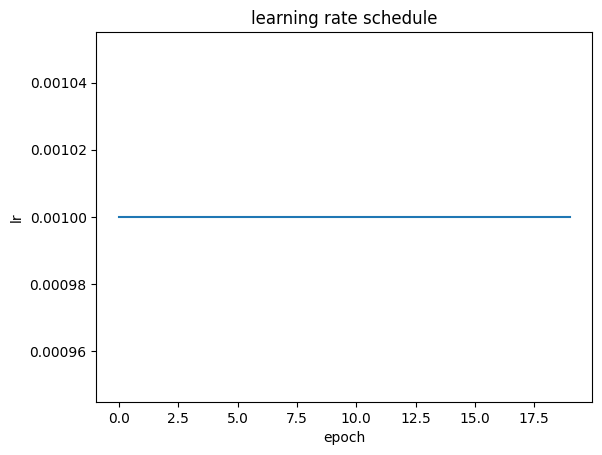

In [11]:
plt.plot(lr_list)

plt.title('learning rate schedule')
plt.xlabel('epoch')
plt.ylabel('lr')

Text(0, 0.5, 'accuracy')

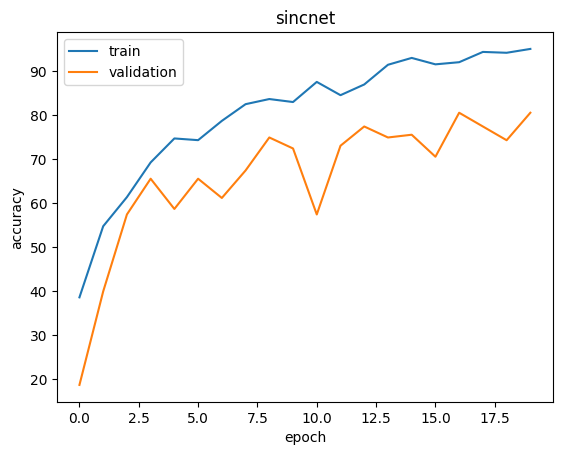

In [12]:
plt.plot(train_acc_list)
plt.plot(val_acc_list)
plt.legend(labels=["train", "validation"],loc=0)


plt.title('sincnet')
plt.xlabel('epoch')
plt.ylabel('accuracy')